In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 APK  'Colab Notebooks'   darknet  'My Drive'   project_orange	 YOLOv3_TFLite


### Unrar Dataset

In [ ]:
# !unrar x "/content/gdrive/MyDrive/project_orange/dataset.rar" "/content/gdrive/MyDrive/project_orange/"

### Check GPU

In [ ]:
!nvidia-smi

Sun Aug 14 17:36:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Clone The Darknet

In [ ]:
%cd /content/gdrive/MyDrive
!git clone https://github.com/AlexeyAB/darknet

/content/gdrive/MyDrive
Cloning into 'darknet'...
remote: Enumerating objects: 15460, done.
remote: Total 15460 (delta 0), reused 0 (delta 0), pack-reused 15460
Receiving objects: 100% (15460/15460), 14.07 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (10385/10385), done.
Checking out files: 100% (2053/2053), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd /content/gdrive/MyDrive/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/gdrive/MyDrive/darknet
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

## 1. EDA

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
dataset_folder = "/content/gdrive/MyDrive/project_orange/dataset"

In [ ]:
files = []

for file in os.listdir(dataset_folder):
  data = []
  filename = file.split(".")
  if filename[-1] != "txt":
    label_path = os.path.join(dataset_folder, "{}.txt".format(filename[0])) 
    with open (label_path) as f:
      lines = f.readlines()
    label = lines[0].replace("\n", "")

    data.append(file)

    label = label.split(" ")
    data.append(int(label[0]))
    data.append(float(label[1]))
    data.append(float(label[2]))
    data.append(float(label[3]))
    data.append(float(label[4]))

    files.append(data)

In [ ]:
df = pd.DataFrame()
filename = []
label = []
x = []
y = []
w = []
h = []
for file in files:
  filename.append(file[0])
  label.append(file[1])
  x.append(file[2])
  y.append(file[3])
  w.append(file[4])
  h.append(file[5])

df['filename'] = filename
df['label'] = label
df['x'] = x
df['y'] = y
df['w'] = w
df['h'] = h

df.to_csv('/content/gdrive/MyDrive/project_orange/data.csv', columns=['filename', 'x', 'y', 'w', 'h', 'label'], index=False)

In [ ]:
path_data = '/content/gdrive/MyDrive/project_orange/data.csv'
df_data = pd.read_csv(path_data)

In [ ]:
df_data.head()

,filename,x,y,w,h,label
0,Jeruk Purut (156).jpg,0.511111,0.505990,0.390741,0.223438,2
1,Jeruk Nipis (1312).jpg,0.512500,0.592708,0.489815,0.332292,1
2,Jeruk Nipis (1433).jpg,0.536111,0.545052,0.566667,0.285938,1
3,Jeruk Nipis (1958).jpg,0.535185,0.536979,0.446296,0.251042,1
4,Jeruk Purut (554).jpg,0.535185,0.500521,0.459259,0.212500,2


### Plot a sample train image and label

1 0.536111 0.545052 0.566667 0.285938



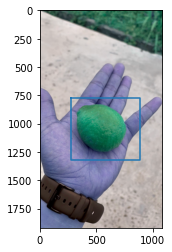

In [ ]:
orange_image = os.path.join(dataset_folder, "{}.jpg".format("Jeruk Nipis (1433)"))
orange_label = os.path.join(dataset_folder, "{}.txt".format("Jeruk Nipis (1433)"))

im_read = cv2.imread(orange_image)
plt.imshow(im_read)

height, width, rgb = im_read.shape

with open(orange_label, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*width
        y = (rcy-rh/2)*height
        w = rw*width
        h = rh*height
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

### Split Dataset

In [ ]:
X = df_data.iloc[:, 0]
y = df_data.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(len(X_train))
print(len(X_test))

1712
735


In [ ]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for filename in series:
            line = "{}\n".format(os.path.join(img_dir, "{}".format(filename)))
            f.write(line)

In [ ]:
metadata_dir = "/content/gdrive/MyDrive/project_orange/cfg"
img_dir = "/content/gdrive/MyDrive/project_orange/dataset"

write_train_list(metadata_dir, img_dir, "train.txt", X_train)
write_train_list(metadata_dir, img_dir, "test.txt", X_test)

### Compile Darknet using NVIDIA GPU

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

In [ ]:
!cp cfg/yolov3-tiny.cfg cfg/yolov3_training.cfg
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=18@' cfg/yolov3_training.cfg

In [ ]:
!mkdir "/mydrive/project_orange/yolov3_w1"

In [ ]:
!echo "Class_Name" > data/obj.names
!echo -e 'classes= 1\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov3_w1' > data/obj.data
!mkdir data/obj

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

# Training

In [ ]:
!./darknet detector train /content/gdrive/MyDrive/project_orange/cfg/orange.data /content/gdrive/MyDrive/project_orange/cfg/yolov3-tiny.cfg /content/gdrive/MyDrive/project_orange/cfg/darknet53.conv.74 -dont_show 

Streaming output truncated to the last 5000 lines.
 total_bbox = 139441, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.840841), count: 3, class_loss = 0.121574, iou_loss = 0.117508, total_loss = 0.239082 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 139444, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.878651), count: 3, class_loss = 0.272509, iou_loss = 0.220125, total_loss = 0.492634 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 139447, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.826555), count: 3, class_loss = 0.274521, 

In [ ]:
!./darknet detector map /content/gdrive/MyDrive/project_orange/cfg/orange.data /content/gdrive/MyDrive/project_orange/cfg/yolov3-tiny.cfg /content/gdrive/MyDrive/project_orange/backup_5/yolov3-tiny_final.weights

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 con

In [ ]:
!./darknet detector recall /content/gdrive/MyDrive/project_orange/cfg/orange.data /content/gdrive/MyDrive/project_orange/cfg/yolov3-tiny.cfg /content/gdrive/MyDrive/project_orange/backup/yolov3-tiny_final.weights

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 con

In [ ]:
!./darknet detector test /content/gdrive/MyDrive/project_orange/cfg/orange.data /content/gdrive/MyDrive/project_orange/cfg/yolov3-tiny.cfg /content/gdrive/MyDrive/project_orange/backup_1/yolov3-tiny_final.weights /content/gdrive/MyDrive/project_orange/testing/Jeruk_Nipis_1500.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256    

# Convert .weights to tensorflow

In [ ]:
!pip install tensorflow==1.15.2
!pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 37 kB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 3.8 MB 14.1 MB/s 
     |████████████████████████████████| 503 kB 56.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3a5b071f55f38613bf622b6903098875e68c3e26a0c064e7b91bdc85650cd7e9
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
!git clone https://github.com/mystic123/tensorflow-yolo-v3

Cloning into 'tensorflow-yolo-v3'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 226 (delta 2), reused 2 (delta 0), pack-reused 219
Receiving objects: 100% (226/226), 63.05 KiB | 3.32 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [ ]:
!python /content/tensorflow-yolo-v3/convert_weights_pb.py --class_names "/content/gdrive/MyDrive/project_orange/convert/classes.txt" --weights_file "/content/gdrive/MyDrive/project_orange/convert/yolov3-tiny_final.weights" --data-format "NHWC" --tiny

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0808 06:39:55.636415 140078598825856 module_wrapper.py:139] From /content/tensorflow-yolo-v3/convert_weights_pb.py:42: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0808 06:39:55.650496 140078598825856 module_wrapper.py:139] From /content/tensorflow-yolo-v3/convert_weights_pb.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

Instructions for updating:
Please use `layer.__call__` method instead.
W0808 06:39:55.660040 140078598825856 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/layers/python/layers

## Setup tensorflow 2.x

In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 1.15.2
Uninstalling tensorflow-1.15.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.15.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.2


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 4.6 kB/s 
     |████████████████████████████████| 15.7 MB 50.2 MB/s 
     |████████████████████████████████| 438 kB 71.1 MB/s 
     |████████████████████████████████| 1.6 MB 59.7 MB/s 
     |████████████████████████████████| 5.8 MB 37.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [ ]:
import tempfile
import os
import glob

## Navigate to tensorflow-yolo-v3 repository

In [ ]:
%cd tensorflow-yolo-v3/

/content/tensorflow-yolo-v3


## Check input and output nodes of neural network

In [ ]:
import tensorflow.compat.v1 as tf
gf = tf.GraphDef()   
m_file = open('/content/frozen_darknet_yolov3_model.pb','rb')
gf.ParseFromString(m_file.read())

with open('somefile.txt', 'a') as the_file:
     for n in gf.node:
         the_file.write(n.name+'\n')

file = open('somefile.txt','r')
data = file.readlines()
output = data[len(data)-1]
print("Output array = ", output)

file.seek ( 0 )
input=file.readline()
print("Input array = ", input)

Output array =  output_boxes

Input array =  inputs



## Convert frozen_darknet_yolov3_model.pb to .tflite

In [ ]:
# Reference: https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/DeepLabV3/DeepLab_TFLite_COCO.ipynb
# Load the TensorFlow model
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph 
# because some operations (ArgMax) might not support the delegates. 
# Insepct the graph using Netron https://lutzroeder.github.io/netron/
converter = tf.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/frozen_darknet_yolov3_model.pb', 
    input_arrays = ['inputs'],   # Here, 'inputs' is the value of input array from Step 7b
    output_arrays = ['output_boxes'], # Here, 'output_boxes' is the value of output array from Step 7b
    input_shapes={'inputs': [1, 416, 416, 3]} # Here, 'inputs' is the value of input array from Step 7b
)

# Optional: Perform the simplest optimization known as post-training dynamic range quantization.
# https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
# You can refer to the same document for other types of optimizations.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert to TFLite Model
tflite_model = converter.convert()

_, dynamic_tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(dynamic_tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize('/content/frozen_darknet_yolov3_model.pb')
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training dynamic range quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  34768041 bytes
TFLite Model is      8783944 bytes
Post training dynamic range quantization saves 25984097 bytes


In [ ]:
!ls -lh {dynamic_tflite_path}

-rw------- 1 root root 8.4M Aug  8 06:45 /tmp/tmpsiwuwy5_.tflite


## Move the .tflite model into your Google drive folder

In [ ]:
tflite_file = ''
tflite_file = tflite_file.join(glob.glob("/tmp/*.tflite")) # Find the temp file of type .tflite
tflite_file = tflite_file[5:len(tflite_file)]  # Extract .tflite file name.

%cd ..
%cd ../tmp
os.rename(tflite_file, 'detect.tflite') # Rename the temp .tflite to detect.tflite
%mv detect.tflite ../content/gdrive/MyDrive/YOLOv3_TFLite/  # Move detect.tflite to Goolge Drive

/
/tmp


## Model inference

In [ ]:
interpreter = tf.lite.Interpreter(model_path='../content/gdrive/MyDrive/YOLOv3_TFLite/detect.tflite')

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'inputs',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 416, 416,   3], dtype=int32),
  'shape_signature': array([  1, 416, 416,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 154,
  'name': 'output_boxes',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 2535,    8], dtype=int32),
  'shape_signature': array([   1, 2535,    8], dtype=int32),
  'sparsity_parameters': {}}]

## Navigate to google drive

In [ ]:
%cd ../content/gdrive/MyDrive/YOLOv3_TFLite/

/content/gdrive/MyDrive/YOLOv3_TFLite


## Test the model

In [ ]:
!python test_tflite.py

# Get Confusion Matrix

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
with open('/content/gdrive/MyDrive/project_orange/cfg/test.txt') as f:
  lines = f.readlines()

['/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1500).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1789).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (468).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (148).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (278).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (521).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1325).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (517).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1863).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (717).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (514).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (715).jpg\n', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (792).jpg\n', '/content/gdrive/MyDrive/project_

In [ ]:
test_filename = []
for i in lines:
  new = i.replace("\n", "")
  test_filename.append(new)

print(test_filename)

['/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1500).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1789).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (468).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (148).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (278).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (521).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1325).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (517).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Nipis (1863).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (717).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (514).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau (715).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Purut (792).jpg', '/content/gdrive/MyDrive/project_orange/dataset/Jeruk Limau

In [ ]:
path_data = '/content/gdrive/MyDrive/project_orange/data.csv'
df_data = pd.read_csv(path_data)

In [ ]:
df_data

,filename,x,y,w,h,label
0,Jeruk Purut (156).jpg,0.511111,0.505990,0.390741,0.223438,2
1,Jeruk Nipis (1312).jpg,0.512500,0.592708,0.489815,0.332292,1
2,Jeruk Nipis (1433).jpg,0.536111,0.545052,0.566667,0.285938,1
3,Jeruk Nipis (1958).jpg,0.535185,0.536979,0.446296,0.251042,1
4,Jeruk Purut (554).jpg,0.535185,0.500521,0.459259,0.212500,2
...,...,...,...,...,...,...
2442,Jeruk Nipis (1304).jpg,0.590278,0.539583,0.312037,0.211458,1
2443,Jeruk Nipis (1557).jpg,0.544907,0.537500,0.408333,0.243750,1
2444,Jeruk Limau (86).jpg,0.536111,0.495052,0.740741,0.449479,0
2445,Jeruk Limau (529).jpg,0.507870,0.450781,0.710185,0.380729,0


In [ ]:
for file in test_filename:
  test = df_data.loc[df_data['filename'] == file.split("/")[-1]]

                    filename         x         y         w         h  label
2222  Jeruk Nipis (1500).jpg  0.555093  0.578906  0.517593  0.283854      1
                    filename         x         y         w         h  label
1228  Jeruk Nipis (1789).jpg  0.525926  0.516406  0.533333  0.288021      1
                   filename         x         y         w         h  label
1159  Jeruk Purut (468).jpg  0.463889  0.449219  0.285185  0.242188      2
                   filename         x         y         w         h  label
1957  Jeruk Limau (148).jpg  0.448611  0.473177  0.652778  0.366146      0
                  filename         x         y         w         h  label
879  Jeruk Purut (278).jpg  0.527315  0.463802  0.628704  0.323437      2
                   filename         x         y         w         h  label
1786  Jeruk Limau (521).jpg  0.504167  0.458073  0.512037  0.335938      0
                    filename         x         y         w         h  label
1477  Jeruk Nipis (132

In [ ]:
print(test)

                   filename         x        y         w         h  label
2030  Jeruk Limau (704).jpg  0.435185  0.54375  0.659259  0.377083      0
